This part focuses on the Data Preprocessing and the Machine Learning Models.


In [92]:
# Import important packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


# Filter out FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# This script is created in Google Colab and therefore the file is loaded from
# The private google drive
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


# Data Preprocessing

Data Preprocessing goals:

- Drop the first column which is an index.
- Handle any missing values.
- Convert categorical variables using Label Encoding.
- Split the data into features (X) and target (y).
- Split these into training and testing sets.

In [93]:
stroke_data = pd.read_csv('stroke_data_cleaned.csv')

# Quick look at the dataset
stroke_data.head()

# Drop the 'Unnamed: 0' column as it's just an index
stroke_data.drop(columns=['Unnamed: 0'], inplace=True)

# Check the values for 'smoking_status' and 'smoking status_status_imp'
#if equal delete the imputed
are_equal = stroke_data['smoking_status'].equals(stroke_data['smoking_status_imp'])

# Drop the imputed column
stroke_data.drop("smoking_status_imp",axis=1,inplace=True)

# Check for any remaining missing values
missing_values = stroke_data.isnull().sum()
stroke_data

# Fill missing values in 'bmi' with the imputed values in 'bmi_imp'
stroke_data['bmi'].fillna(stroke_data['bmi_imp'], inplace=True)
are_equal_1 = stroke_data['bmi'].equals(stroke_data['bmi_imp'])

# Drop the imputed column
stroke_data.drop("bmi_imp",axis=1,inplace=True)

stroke_data.isna().sum()


gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
rounded_age          0
dtype: int64

The first column was removed because we don't need it for the model. There were missing values in the 'bmi' column and were filled with imputed values. As a result we get our cleaned data set without missing values.

It is obvious that our data set contains many categorical variables and in the following we will encode these.

In [105]:
# Avoid introducing spurious ordinality, so better use onehot
#encoder for encoding the variables

# Define the columns to encode with one hot encoder
end_col_onehot = ["gender", "smoking_status", "work_type"]
# Initialize a new dataset, profit later visible
dataset_encoded = stroke_data
encoded_columns=[]

for col in end_col_onehot:
  one_hot = pd.get_dummies(dataset_encoded[col], prefix = col)
  dataset_encoded = dataset_encoded.drop(col, axis=1)
  dataset_encoded = dataset_encoded.join(one_hot)
  #save the names of the encoded columns (useful later for decoding)
  encoded_columns.extend(one_hot.columns.tolist())

# Drop the unencoded columns
dataset_encoded = dataset_encoded.iloc[:,1:]
# Dataset encoded is a separate dataset because we have to save the encoded
# Variables separately in order to decode them as well later...

# Encode with Label Encoder the binary variables ( with only 2 entries)
from sklearn.preprocessing import LabelEncoder
# Define cols
enc_col_le = ["ever_married", "Residence_type"]
label_encoder = LabelEncoder()
# Iterate through cols
for col in enc_col_le:
   dataset_encoded[col] = label_encoder.fit_transform(dataset_encoded[col])

# Ever married : 1 yes 0 no .. residence type urban 1, 0 rural
dataset_encoded.columns


Index(['hypertension', 'heart_disease', 'ever_married', 'Residence_type',
       'avg_glucose_level', 'bmi', 'stroke', 'rounded_age', 'gender_Female',
       'gender_Male', 'gender_Other', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children'],
      dtype='object')

OneHotEncoder and LabelEncoder were used as encoding techniques because of the levels of categories present in the data. Specifically for non-binary categories to avoid spurious ordinality or even introduction of bias OneHoteEncoder was used over LabelEncoding, where for each category of the specific variable (column) a new separate column was created. this way, we also avoided the risk that the models later don't interpret the numerical labels as ordinal values and learn relationships based on the assigned numerical values which leads to incorrect assumptions about the relationships between categories as well. For columns with binary data we used the normal LabelEncoding as visible in the code above.

# Model Training

This section concemtrates on model training. Three different Models are trained:
- Decision Tree
- Random Forest
- Support Vector Machines
- Logistical Regression


After the training, the models will be evaluated using various metrics, such as accuracy (and Kfold Validation Mean accuracy), precision, recall, ROC, precision and F1-score as part of the classification report.
Due to the big imbalace in the data set, we will use the oversamling technique of SMOTE later. Our goal is to see how will the models perform before and after oversampling. Therefore, the training part is divided in two parts; first we train the models without SMOTE and after we train the models on the oversampled data set, in order to see the difference. The evaluation metrics are commented below.



## Training data set and training functions



The standard training/test data split of 80/20 is used.

Since we want to compare the performance of different models at a later point, we considered scaling the data. Additionally, standardization makes the data less sensistive to outliers and will help our models to converge faster and provide more efficiency.

In [95]:
# Divide the training data
X = dataset_encoded.drop(['stroke'], axis=1)  # features
y = dataset_encoded['stroke']  # target

# Split the data again into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Standardizing(scaling) the data
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)


The ML training procedure is based on three functions overall;

1) we have the standard training function where we fit the split datasets into the four models we want to train.

2) we have an additional function which saves the trained data for each model into a separate dictionary. This function is later needed for our StreamLit application.

3) we have a function which evaluates the previously mentioned metrics for model evaluation and cross validation.

In the code every function is separately described.

In [96]:
# Define training function
def train_models(models, X_train, y_train):
    """
    Trains multiple classification models.

    Input parameters:
    - models: list of list of tupels containing the model name and instances,
    - X_train: training dataframe with the feautres columns (variables)
    - y_train: training dataframe with the target column (variable)

    Returns:
    - trained_models: Dictionary containing trained model instances.
    """

    trained_models = {}

    for model_name, model_instance in models:
        model = model_instance
        model.fit(X_train, y_train)
        trained_models[model_name] = model

    return trained_models

# Save hte trained data for future predictions
def train_saving(models, trained_models, X_train, y_train):
    """
    Saves training data for multiple classification models.
    Needed for StreamLit later

    Input parameters:
    - models: List of ist of tupels containing the model name and instances,
    - trained_models: Function for training models
    - X_train: Training dataframe with the feautres columns (variables)
    - y_train: Training dataframe with the target column (variable)

    Returns:
    - trained_models: Dictionary containing trained model instances with saved training data.
    """
    # Save the training data for each model
    for model_name, trained_data in trained_models.items():
        trained_models[model_name] = {
            'model': trained_data['model'],
            'X_train': X_train,
            'y_train': y_train
        }

    return trained_models

# Model evaluation
def evaluate_models(models, trained_models, X_test, y_test):
    """
    Evaluates multiple classification models.

    Input parameters:
    - models: List of list of tupels containing the model name and instances,
    - trained_models: Function for training models
    - X_test: Testing dataframe with the feautures columns (variables)
    - y_test: Testing dataframe with the target column (variable)

    Returns:
    - results: List of evaluation results for each model.
    """

    results = []

    for model_name, model_instance in models:
        evaluation = []
        model = trained_models[model_name]

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Compute evaluation metrics
        cm = confusion_matrix(y_test, y_pred)  # Confusion Matrix
        k_accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)  # K-Fold Validation
        roc_sc = roc_auc_score(y_test, y_pred)  # ROC AUC Score
        precision = precision_score(y_test, y_pred)  # Precision Score
        recall = recall_score(y_test, y_pred)  # Recall Score
        f1 = f1_score(y_test, y_pred)  # F1 Score

        # Print evaluation metrics
        print(f"{model_name}:")
        print("Confusion Matrix:")
        print(cm)
        print('Accuracy Score:', accuracy_score(y_test, y_pred))
        print("K-Fold Validation Mean Accuracy: {:.2f} ".format(k_accuracies.mean()))
        print("Standard Deviation: {:.2f} ".format(k_accuracies.std()))
        print('ROC AUC Score: {:.2f}'.format(roc_sc))
        print('Precision: {:.2f}'.format(precision))
        print('Recall: {:.2f}'.format(recall))
        print('F1: {:.2f}'.format(f1))
        print('*'*20)

        # Append evaluation results to list
        evaluation.append(model_name)
        evaluation.append((accuracy_score(y_test, y_pred)))
        evaluation.append(k_accuracies.mean())
        evaluation.append(k_accuracies.std())
        evaluation.append(roc_sc)
        evaluation.append(precision)
        evaluation.append(recall)
        evaluation.append(f1)
        results.append(evaluation)

    return results

import matplotlib.pyplot as plt
import seaborn as sns

def plot_evaluation_metrics(results):
    """
    Plots evaluation metrics for different models.

    Input parameters:
    - results: List of evaluation results we obtained for each model.
    """

    # Convert results to DataFrame for easier plotting
    df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'K-Fold Mean Accuracy',
                                        'K-Fold Std', 'ROC AUC',
                                        'Precision', 'Recall', 'F1'])

    # Plot evaluation metrics
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    metrics = ['Accuracy', 'K-Fold Mean Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1']
    for i, metric in enumerate(metrics):
        ax = axes.flatten()[i]
        sns.barplot(x='Model', y=metric, data=df, ax=ax)
        ax.set_title(f'{metric}')
        ax.set_xticks(range(len(df['Model'])))
        ax.set_xticklabels(df['Model'], rotation=45, ha='right')
        ax.set_ylabel(metric)
        ax.set_xlabel('Model')
        ax.grid(alpha=0.99)
    plt.tight_layout()
    plt.show()





## Evaluation Metrics



Starting point for our model evaluation were the two research questions we have proposed in the prelimiry study. Considered the specific characterstics of our imbalanced and later oversampled dataset, to make the final decision on which model to chose was a challenging step.
As part of the model evaluation, although we include several metrics in our code, we have decided to focus on two key metrics: recall (sensitivity) and F1 score. To adress the question why we chose exactly these two we had the following reasons:
- Positive cases remain our focus: Recall(senstivity) specifically measures the proportion of true positive predictions (instances where the patient had a stroke) among all actual positive cases in the dataset. Given that our dataset is imbalanced, with stroke cases being the minority, recall allows us to evaluate the model's performance while focusing on these critical positive cases.

- Identifying a higher likelihood of stroke occurrence: The F1 score, being the harmonic mean or balanced value of precision and recall, provides a good trade-off between these two metrics for imbalanced datasets. It doesn't ignore false positives and false negatives, tending to mitigate the potential presence of bias introduced by SMOTE. By considering both precision and recall, the F1 score gives us insight into the model's ability to capture positive cases while minimizing misclassifications.

Additionally, we included a confusion matrix to have a better representation on the count of the true and false positives.

Both metrics align with our first research question: "How likely is it that a patient can experience a stroke based on various risk factors?"

Our second question, "Which machine learning models have higher accuracy in predicting the likelihood of stroke occurrence?" is straightforward to address where we can simply compare different accuracy scores, but it presents challenges when dealing with predicting positive cases. This difficulty arises from the problem of an imbalanced dataset, which we address by applying SMOTE. Consequently, we cannot rely solely on model accuracy as a metric. There are several reasons for this:

- SMOTE generates synthetic samples for the minority class, introducing some noise or uncertainty regarding the real-world distribution of the minority class.
- If the model performs well on the majority class, it might achieve a higher accuracy, which can be misleading in our case.

Overall, we  consider other evaluation metrics such as precision and recall, as described above. These metrics provide a more comprehensive understanding of the model's performance, particularly in scenarios involving imbalanced datasets as ours.

Logistic Regression:
Confusion Matrix:
[[722 250]
 [ 10  40]]
Accuracy Score: 0.7455968688845401
K-Fold Validation Mean Accuracy: 0.74 
Standard Deviation: 0.03 
ROC AUC Score: 0.77
Precision: 0.14
Recall: 0.80
F1: 0.24
********************
SVM:
Confusion Matrix:
[[757 215]
 [ 20  30]]
Accuracy Score: 0.7700587084148728
K-Fold Validation Mean Accuracy: 0.70 
Standard Deviation: 0.03 
ROC AUC Score: 0.69
Precision: 0.12
Recall: 0.60
F1: 0.20
********************
Decision Tree:
Confusion Matrix:
[[946  26]
 [ 44   6]]
Accuracy Score: 0.9315068493150684
K-Fold Validation Mean Accuracy: 0.92 
Standard Deviation: 0.01 
ROC AUC Score: 0.55
Precision: 0.19
Recall: 0.12
F1: 0.15
********************
Random Forest:
Confusion Matrix:
[[969   3]
 [ 50   0]]
Accuracy Score: 0.9481409001956947
K-Fold Validation Mean Accuracy: 0.95 
Standard Deviation: 0.00 
ROC AUC Score: 0.50
Precision: 0.00
Recall: 0.00
F1: 0.00
********************


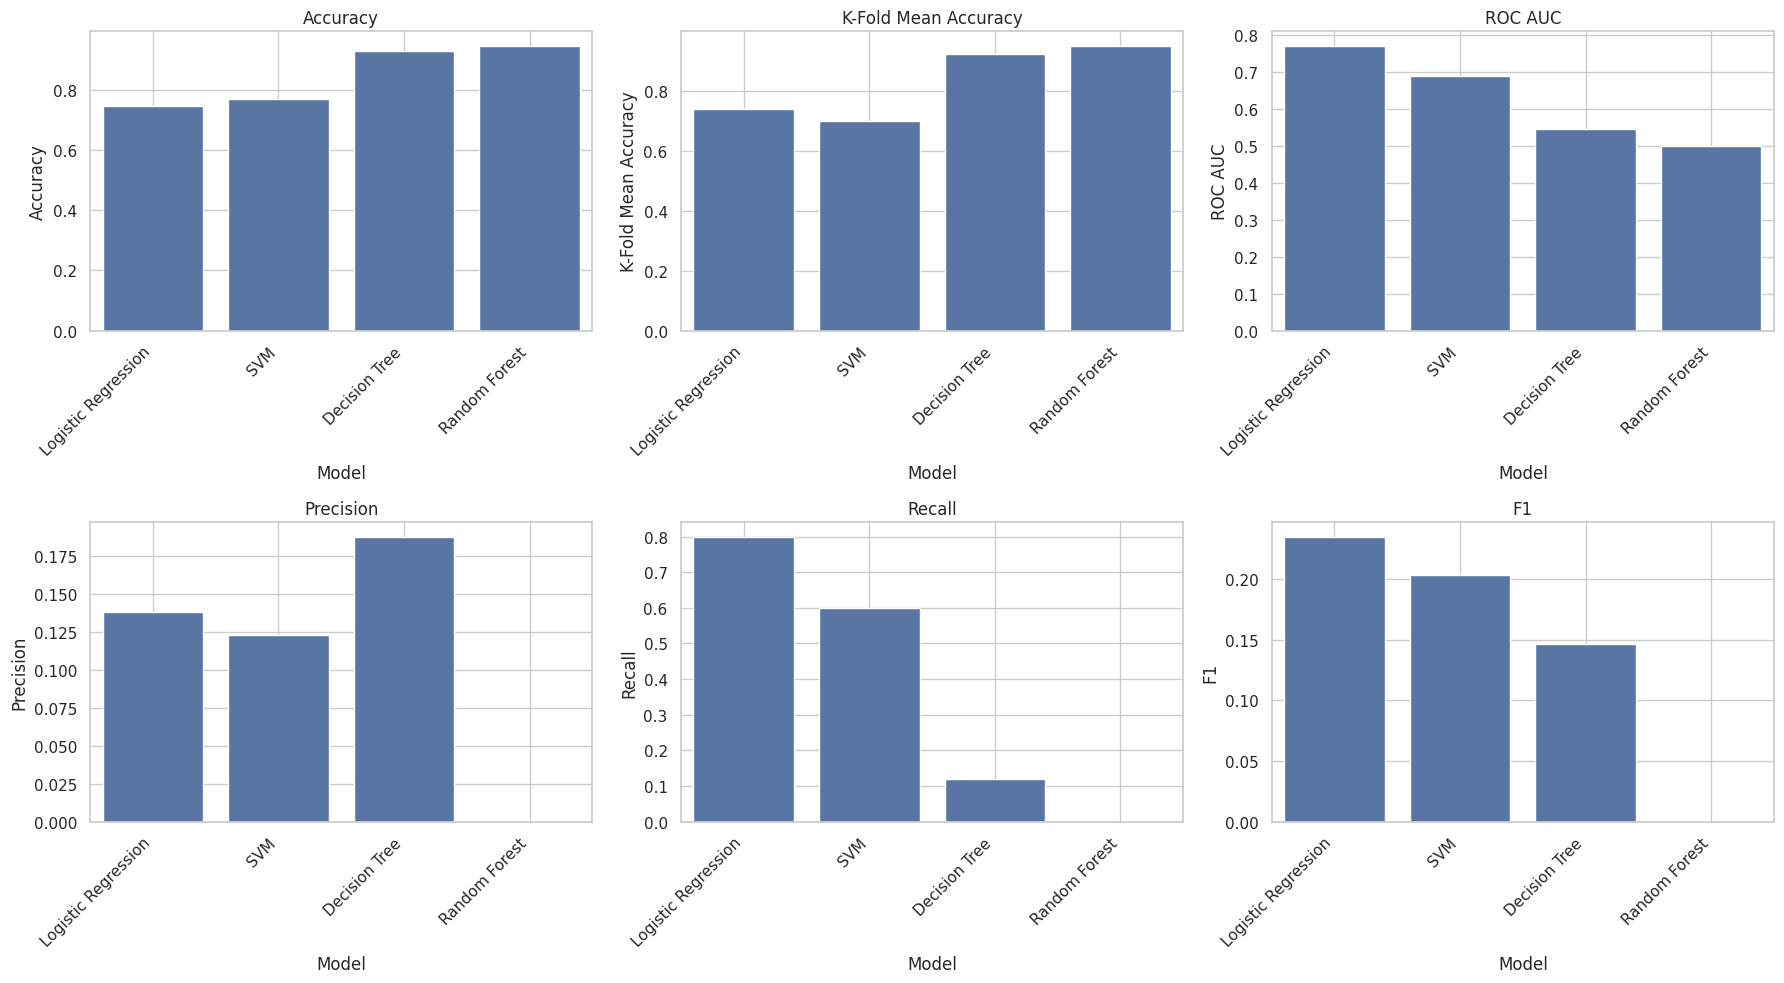

In [97]:
# Define the models
models = [
    ['Logistic Regression', LogisticRegression(random_state=0,max_iter=10000,class_weight='balanced')],
    ['SVM', SVC(random_state=0, class_weight = 'balanced')],
    ['Decision Tree', DecisionTreeClassifier(random_state=0, class_weight = 'balanced')],
    ['Random Forest', RandomForestClassifier(random_state=0, class_weight = 'balanced')],
]

# Train models
trained_models = train_models(models, X_train_std, y_train)

# Evaluate models
evaluation_results = evaluate_models(models, trained_models, X_test_std, y_test)

# Plot the results
graphs = plot_evaluation_metrics(evaluation_results)


## SMOTE




SMOTE is applied as a measure to imbalaced classes within the stroke data set.

SMOTE APPLY 

Data shapes before oversampling were (4088, 19) and (4088,)
Data shapes after oversampling are (7778, 19) and (7778,)
0    3889
1    3889
Name: stroke, dtype: int64


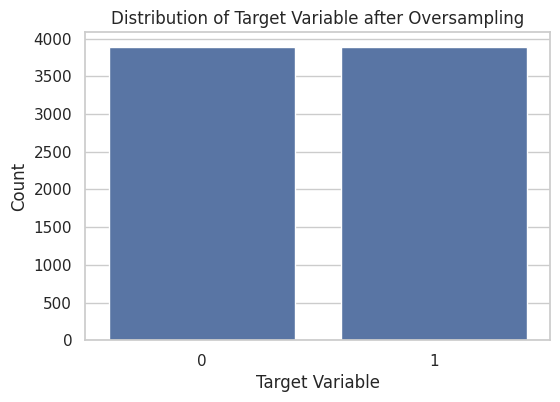

In [98]:
print("SMOTE APPLY \n")
#it makes sence to apply smote because the data is biased and imbalanced which
#may cause biased models at the end which will fail to make accurate predictions

#initiation of smote
oversample = SMOTE(random_state=0)
#fit smote to training sample
X_res, y_res = oversample.fit_resample(X_train_std, y_train)
print('Data shapes before oversampling were {0} and {1}'.format(X_train_std.shape, y_train.shape))
print('Data shapes after oversampling are {0} and {1}'.format(X_res.shape, y_res.shape))
print(y_res.value_counts())

#distribution after oversampling
plt.figure(figsize=(6, 4))
sns.countplot(x=y_res)
plt.title('Distribution of Target Variable after Oversampling')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.show()




Logistic Regression:
Confusion Matrix:
[[722 250]
 [ 10  40]]
Accuracy Score: 0.7455968688845401
K-Fold Validation Mean Accuracy: 0.74 
Standard Deviation: 0.03 
ROC AUC Score: 0.77
Precision: 0.14
Recall: 0.80
F1: 0.24
********************
SVM:
Confusion Matrix:
[[803 169]
 [ 26  24]]
Accuracy Score: 0.8091976516634051
K-Fold Validation Mean Accuracy: 0.70 
Standard Deviation: 0.03 
ROC AUC Score: 0.65
Precision: 0.12
Recall: 0.48
F1: 0.20
********************
Decision Tree:
Confusion Matrix:
[[886  86]
 [ 37  13]]
Accuracy Score: 0.8796477495107632
K-Fold Validation Mean Accuracy: 0.92 
Standard Deviation: 0.01 
ROC AUC Score: 0.59
Precision: 0.13
Recall: 0.26
F1: 0.17
********************
Random Forest:
Confusion Matrix:
[[925  47]
 [ 40  10]]
Accuracy Score: 0.9148727984344422
K-Fold Validation Mean Accuracy: 0.95 
Standard Deviation: 0.00 
ROC AUC Score: 0.58
Precision: 0.18
Recall: 0.20
F1: 0.19
********************


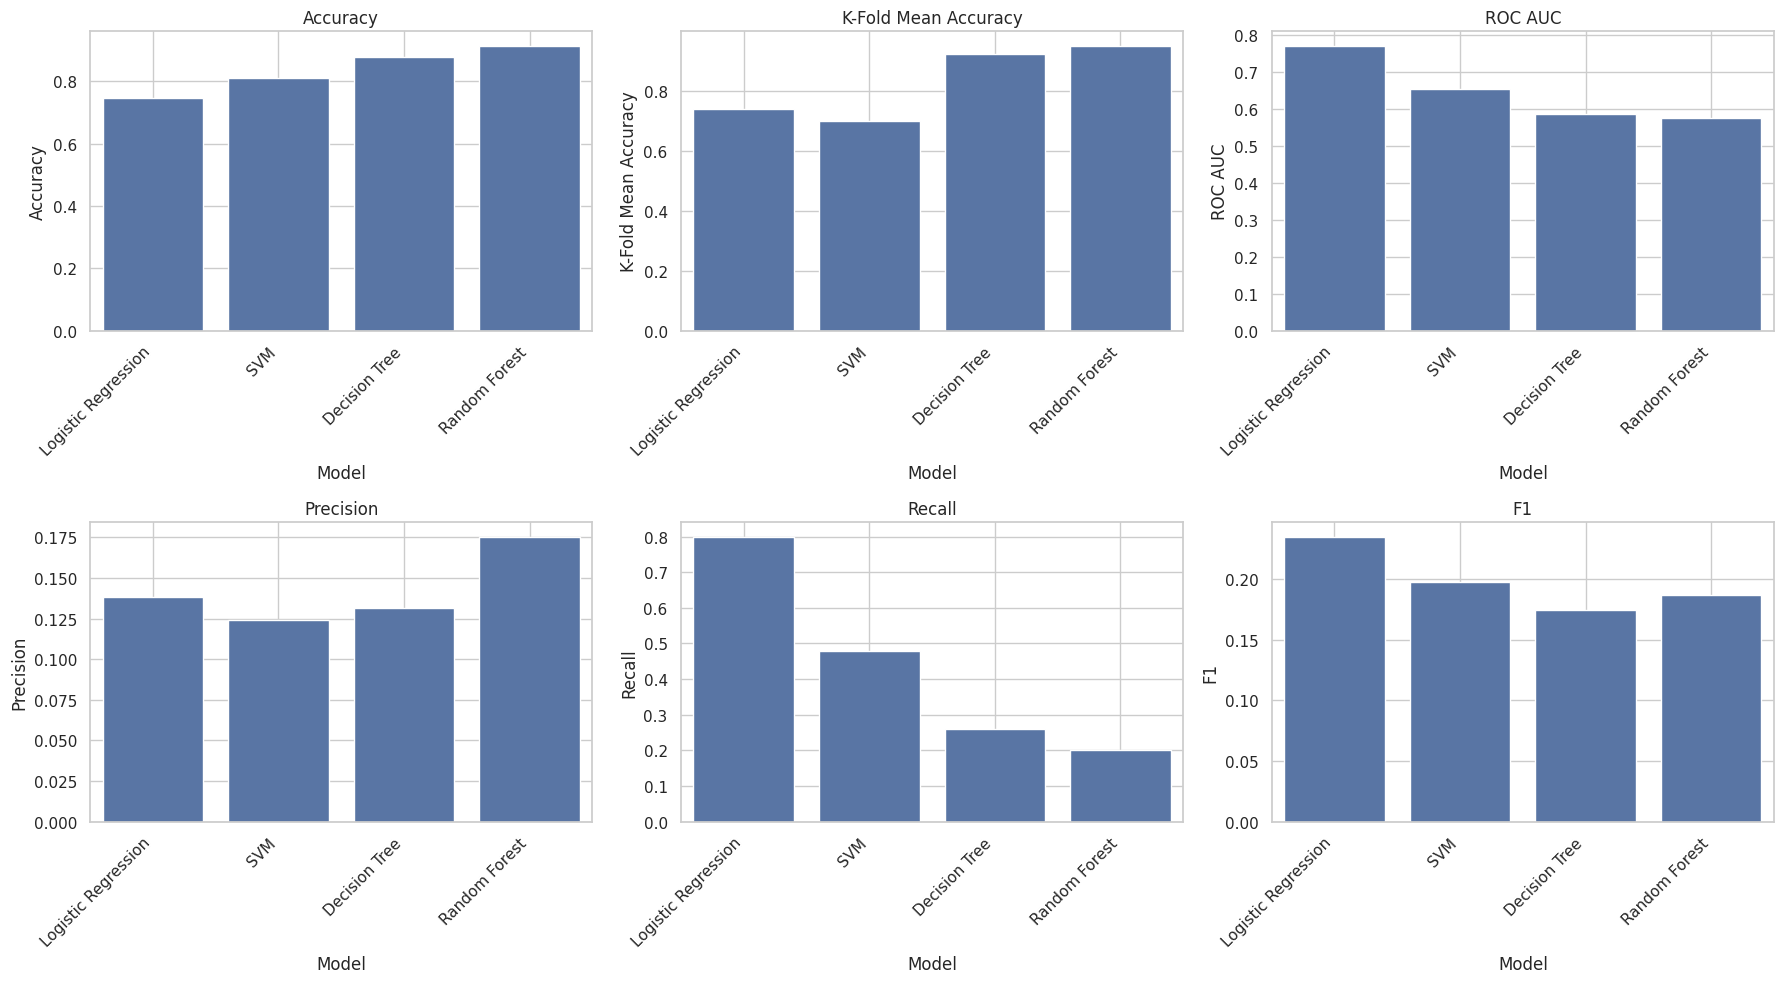

In [104]:
models_SMOTE = [
    ['Logistic Regression', LogisticRegression(random_state=0,max_iter=10000,class_weight='balanced')],
    ['SVM', SVC(random_state=0,class_weight='balanced')],
    ['Decision Tree', DecisionTreeClassifier(random_state=0, class_weight='balanced')],
    ['Random Forest', RandomForestClassifier(random_state=0, class_weight='balanced')],
]

# Train models
trained_models_SMOTE = train_models(models_SMOTE, X_res, y_res)

# Evaluate models
evaluation_results_SMOTE = evaluate_models(models_SMOTE, trained_models_SMOTE, X_test_std, y_test)

# Plot the results
graphs_SMOTE = plot_evaluation_metrics(evaluation_results_SMOTE)



COMMENT THE RESULTS ----> Decision: LOG REGRESSION trotz low accuracy

VICTOR:

- selected model in terms of research questions log regression (although it has lower accuracy).. this is based on F1 score and recall.

- variable to predict:   y_pred (we predict stroke occurance, if 0 or 1)

        # Predict on the test set
        y_pred = model.predict(X_test)

  i assume you predict the likelihood of the occurance based on the different risk factors (columns) in the Streamlit --> this will answer our reasearch question!!

- we basically used all variables.. these are all columns
Index(['hypertension', 'heart_disease', 'ever_married', 'Residence_type',
       'avg_glucose_level', 'bmi', 'stroke', 'rounded_age', 'gender_Female',
       'gender_Male', 'gender_Other', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children'],
      dtype='object')